In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns


In [2]:
train_df = pd.read_csv("../../Data_lab1/mitbih_train.csv", header=None)
test_df = pd.read_csv("../../Data_lab1/mitbih_test.csv", header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_df.isnull().sum().sum()
test_df.isnull().sum().sum()


np.int64(0)

In [5]:
X_train = train_df.iloc[:, :-1]  
y_train = train_df.iloc[:, -1]    

X_test  = test_df.iloc[:, :-1]
y_test  = test_df.iloc[:, -1]

In [6]:
class_names = {
    0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"
}

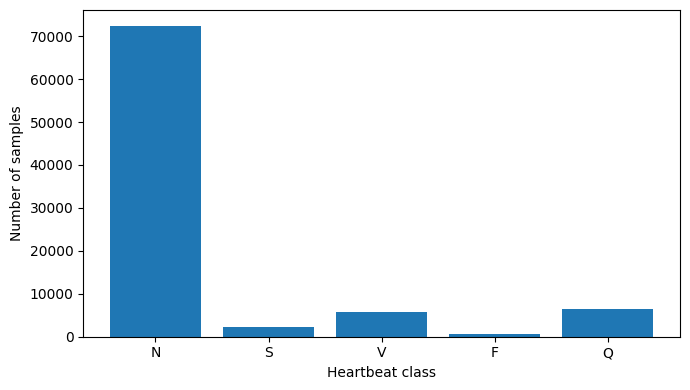

In [15]:
# Class distribution
counts = y_train.value_counts().sort_index()

plt.figure(figsize=(7,4))
plt.bar(
    [class_names[i] for i in counts.index],
    counts.values
)
plt.xlabel("Heartbeat class")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()


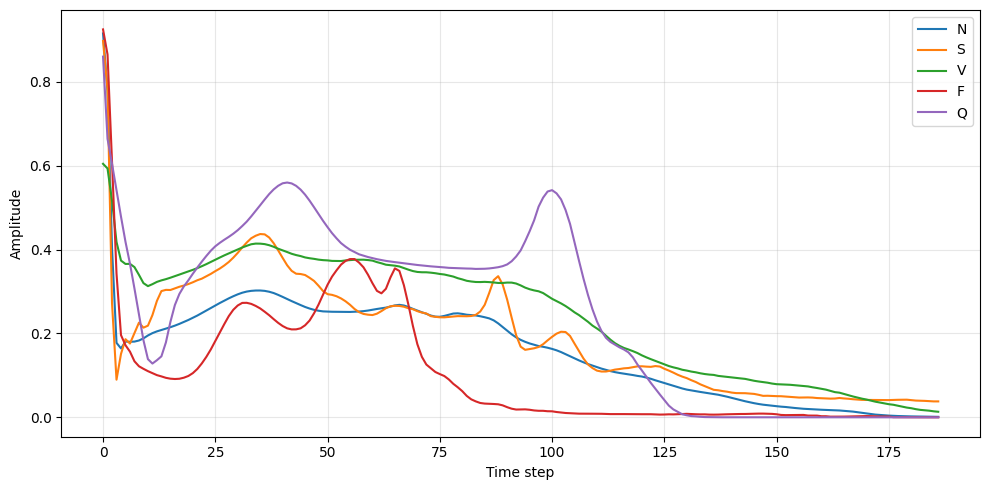

In [8]:
# Average ECG Waveform by Class (MIT-BIH Training Set)
plt.figure(figsize=(10, 5))

for cls, name in class_names.items():
    class_data = train_df[train_df.iloc[:, -1] == cls]
    signals = class_data.iloc[:, :-1].values
    mean_signal = signals.mean(axis=0)
    
    plt.plot(mean_signal, label=name)

plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Model

In [9]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

In [10]:
# Standardization
scaler = StandardScaler()
X_tr  = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Reshape for CNN: (samples, time_steps, channels)
X_tr = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
# 1D CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(5, activation='softmax')   # 5 classes
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\ML_in_Medicine\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2752)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       176,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,013 (730.52 KB)

 Trainable params: 187,013 (730.52 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr),
    y=y_tr
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.241626420127869), 1: np.float64(7.875862068965517), 2: np.float64(3.02545594163947), 3: np.float64(27.312998266897747), 4: np.float64(2.722805805114029)}


In [13]:
history = model.fit(
    X_tr,
    y_tr,
    epochs=25,
    batch_size=128,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7020 - loss: 0.6892 - val_accuracy: 0.8137 - val_loss: 0.5786
Epoch 2/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8019 - loss: 0.4422 - val_accuracy: 0.8489 - val_loss: 0.4468
Epoch 3/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8390 - loss: 0.3520 - val_accuracy: 0.9049 - val_loss: 0.3256
Epoch 4/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8564 - loss: 0.3168 - val_accuracy: 0.9076 - val_loss: 0.2932
Epoch 5/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8698 - loss: 0.2788 - val_accuracy: 0.9142 - val_loss: 0.2614
Epoch 6/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8786 - loss: 0.2529 - val_accuracy: 0.9403 - val_loss: 0.2085
Epoch 7/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8874 - loss: 0.2238 - val_accuracy: 0.9411 - val_loss: 0.1898
Epoch 8/25
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8966 - loss: 0.2094 - val_accuracy: 0.

#### Evaluation

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Accuracy: 0.9641878311712041


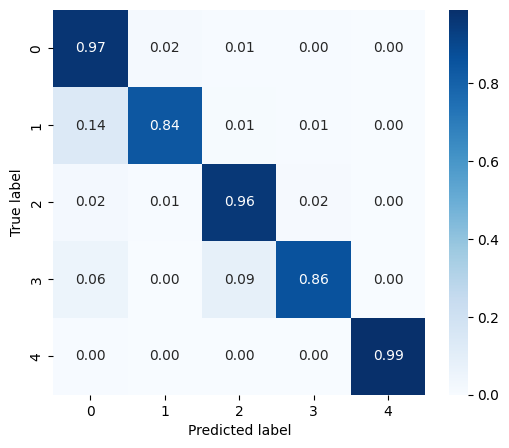

              precision    recall  f1-score   support

           N     0.9930    0.9674    0.9800     18118
           S     0.5742    0.8417    0.6827       556
           V     0.9016    0.9558    0.9279      1448
           F     0.5472    0.8580    0.6683       162
           Q     0.9713    0.9888    0.9800      1608

    accuracy                         0.9642     21892
   macro avg     0.7975    0.9223    0.8478     21892
weighted avg     0.9714    0.9642    0.9667     21892



In [18]:
# Predict
y_prob = model.predict(X_test)         
y_pred = np.argmax(y_prob, axis=1)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(6,5))
sns.heatmap( cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['N', 'S', 'V', 'F', 'Q'], digits=4))